In [34]:
# SimPEG functionality
from simpeg.potential_fields import magnetics
from simpeg.utils import plot2Ddata, model_builder, download
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils
)

# discretize functionality
from discretize import TensorMesh, TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
from discretize.utils import mkvc

mpl.rcParams.update({"font.size": 14})

In [37]:
# Load topography
xyz_topo = np.loadtxt("Topografia_30k_puntos_SGC.txt")
xyz_topo

array([[4.73020641e+06, 2.04878027e+06, 1.88800000e+03],
       [4.73027160e+06, 2.04878018e+06, 1.85500000e+03],
       [4.73033680e+06, 2.04878008e+06, 1.83900000e+03],
       ...,
       [4.74176033e+06, 2.05882708e+06, 2.77400000e+03],
       [4.74182553e+06, 2.05882698e+06, 2.73700000e+03],
       [4.74189072e+06, 2.05882689e+06, 2.69100000e+03]], shape=(32400, 3))

In [38]:
# Load field data
dobs = np.loadtxt("Estaciones_AGCM_SGC_Magnetometria.txt")
dobs

array([[ 4.73288629e+06,  2.04934817e+06,  1.80150000e+03,
         3.05543862e+01],
       [ 4.73309011e+06,  2.05649808e+06,  1.94380000e+03,
        -3.19199957e+01],
       [ 4.73300020e+06,  2.05696463e+06,  1.98530000e+03,
         2.21741834e+00],
       [ 4.73290436e+06,  2.05744977e+06,  1.99020000e+03,
        -9.72038775e+00],
       [ 4.73288571e+06,  2.05795181e+06,  2.01150000e+03,
         6.26311926e+00],
       [ 4.73302346e+06,  2.05631428e+06,  1.94530000e+03,
        -1.23768427e+01],
       [ 4.73282992e+06,  2.05668772e+06,  1.94670000e+03,
         1.85504510e+01],
       [ 4.73271966e+06,  2.05714471e+06,  1.98710000e+03,
         9.13282784e+00],
       [ 4.73272814e+06,  2.05765860e+06,  2.00910000e+03,
        -1.92294895e+01],
       [ 4.73261278e+06,  2.05633886e+06,  2.18830000e+03,
        -2.04716719e+01],
       [ 4.73221461e+06,  2.05679139e+06,  2.01020000e+03,
        -3.21893864e+00],
       [ 4.73430310e+06,  2.05457402e+06,  2.40280000e+03,
      

In [39]:
topografia = xyz_topo[:, 0:3]
# Definir las ubicaciones de los receptores y los datos observados
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

In [40]:
x = receiver_locations[:, 0]
y = receiver_locations[:, 1]
z = receiver_locations[:, 2]

x1 = topografia[:, 0]
y1 = topografia[:, 1]
z1 = topografia[:, 2]

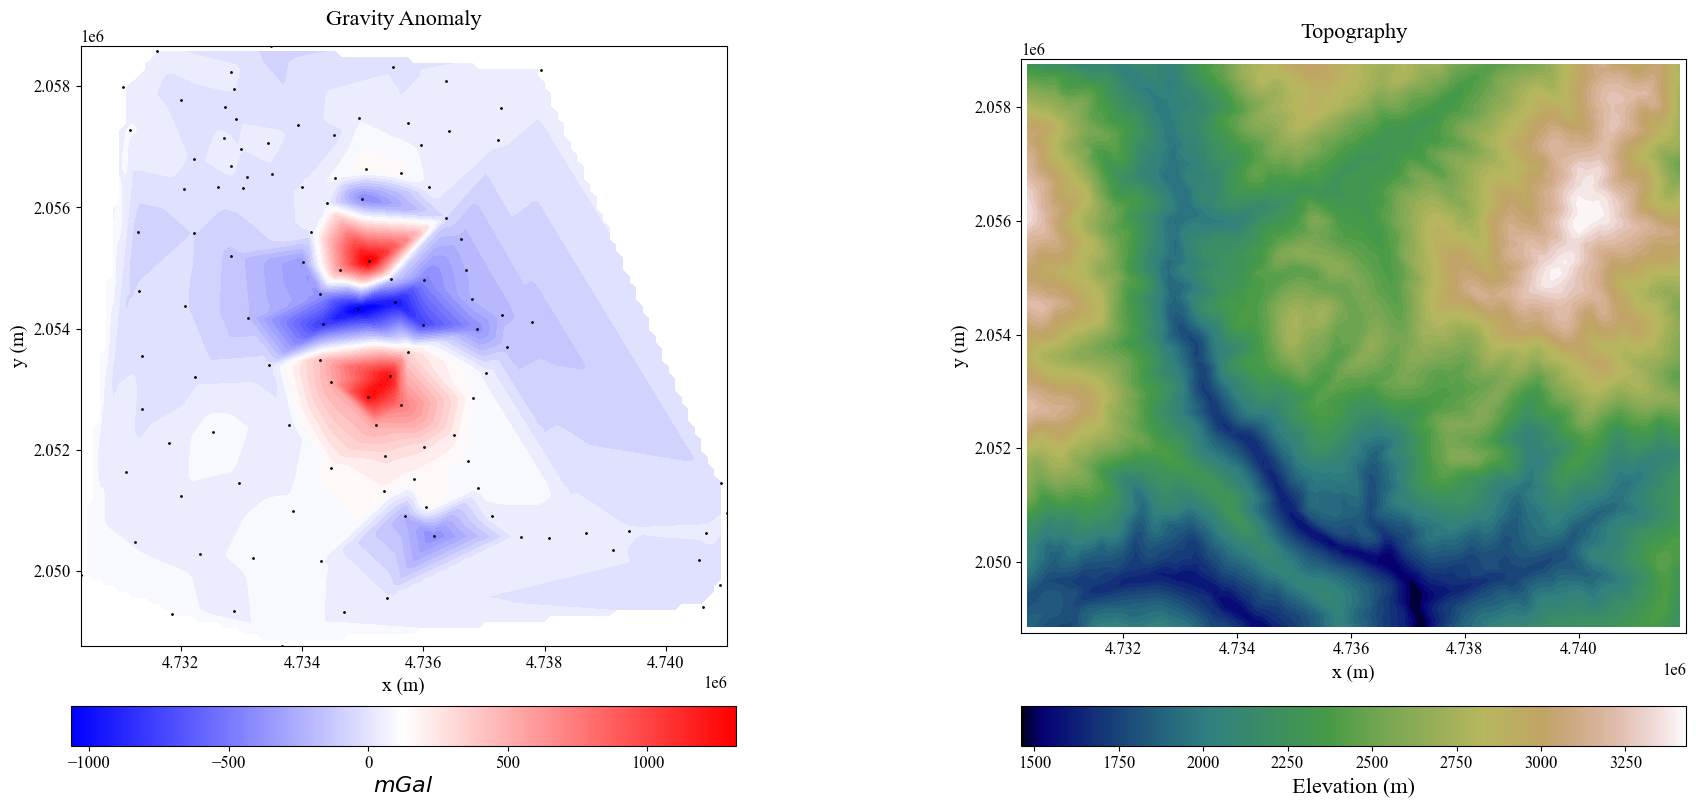

In [41]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# # Normalización de los datos de 'dobs' para el rango de -16 a 8
# norm = mpl.colors.Normalize(vmin=-9, vmax=-1)
# dobs_normalized = norm(dobs)  # Normalización de los datos
# dobs=dobs_normalized

# Crear la figura
fig = plt.figure(figsize=(19, 10))

# Primer gráfico: Anomalía de gravedad
ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.6])

# Usar el método plot2Ddata() para plotear los datos
# Asumiendo que plot2Ddata es una función definida previamente
# Asegúrate de que esta función reciba correctamente los datos normalizados.
plot2Ddata(
    receiver_locations,
    dobs,  # Usamos los datos normalizados
    ax=ax1,
    dataloc=True,
    ncontour=40,
    contourOpts={"cmap": "bwr"},
)

ax1.set_title("Gravity Anomaly", pad=15)
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

# Barra de color para la primera figura
cx1 = fig.add_axes([0.05, 0.25, 0.35, 0.04])
norm1 = mpl.colors.Normalize(vmin=np.min(dobs), vmax=np.max(dobs))
# Usar la normalización para la barra de colores
cbar1 = mpl.colorbar.ColorbarBase(
    cx1, norm=norm1, orientation="horizontal", cmap=mpl.cm.bwr
)
cbar1.set_label("$mGal$", size=16)


# Segundo gráfico: Topografía
ax2 = fig.add_axes([0.55, 0.35, 0.35, 0.6])
plot2Ddata(
    xyz_topo[:, 0:2],  # Coordenadas X, Y de la topografía
    xyz_topo[:, -1],    # Altura de la topografía (Z)
    ax=ax2,
    dataloc=False,
    ncontour=50,
    contourOpts={"cmap": "gist_earth"},
)

ax2.set_title("Topography", pad=15)
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")

# Barra de color para la segunda figura
cx2 = fig.add_axes([0.55, 0.25, 0.35, 0.04])
norm2 = mpl.colors.Normalize(vmin=np.min(xyz_topo[:, -1]), vmax=np.max(xyz_topo[:, -1]))
cbar2 = mpl.colorbar.ColorbarBase(
    cx2, norm=norm2, orientation="horizontal", cmap=mpl.cm.gist_earth
)
cbar2.set_label("Elevation (m)", size=16)

# Mostrar el gráfico
plt.show()

In [42]:
rel_unc = 0.02          # 2% relative (tune: 0.01–0.03)
floor_unc = 0.05        # mGal floor (tune from reductions / repeatability)
sigma = floor_unc + rel_unc * np.abs(dobs)
print(f"Unc stats -> floor={floor_unc:.3f} mGal, rel={100*rel_unc:.1f}%, "
      f"median σ={np.median(sigma):.3f} mGal")

Unc stats -> floor=0.050 mGal, rel=2.0%, median σ=1.028 mGal


In [43]:
# Define the component(s) of the field we are inverting as a list. Here we will
# invert total magnetic intensity data.
components = ["tmi"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)
receiver_list = [receiver_list]

# Define the inducing field
inclination = 26.4397  # inclination [deg]
declination = -8.6336  # declination [deg]
amplitude = 29968.4  # amplitude [nT]

source_field = magnetics.sources.UniformBackgroundField(
    receiver_list=receiver_list,
    amplitude=amplitude,
    inclination=inclination,
    declination=declination,
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

In [44]:
#Definir los datos que serán invertidos
data_object = data.Data(survey, dobs=dobs, standard_deviation=sigma)

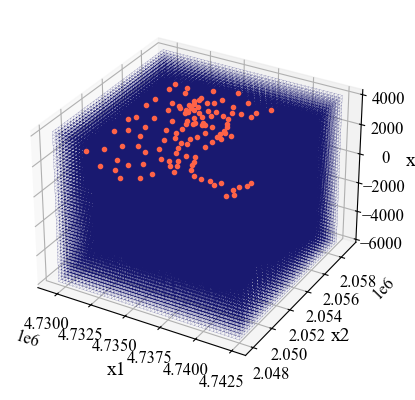

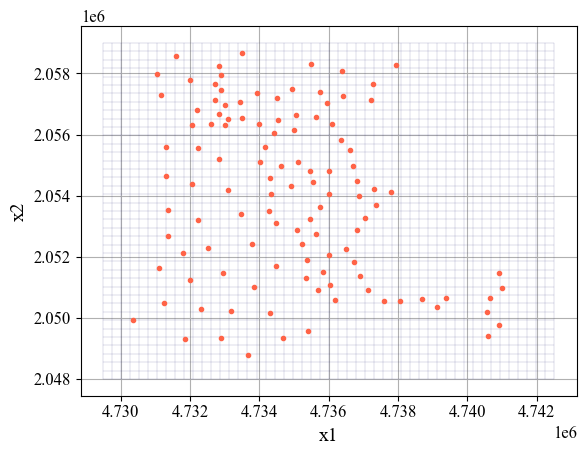

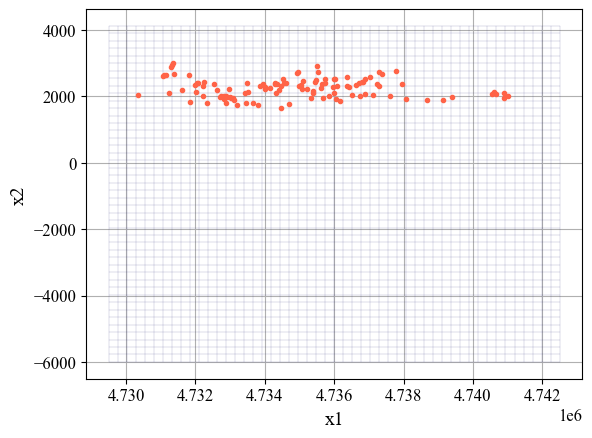

In [45]:
from discretize import TensorMesh
import matplotlib.pyplot as plt

dx = 260 #55
ncx = 50 #55
dy = 275 #55
ncy = 40 #73
dz = 225 #55
ncz = 45 #165


hx = [(dx, ncx)]
hy = [(dy, ncy)]
hz = [(dz, ncz)]
mesh = TensorMesh([hx, hy, hz], x0=[4729500,2048000,-6000])
mesh.plot_grid(color="midnightblue", linewidth=0.1)
plt.plot(x, y, z, '.', color='tomato')

cell_centers = mesh.cell_centers

meshes = TensorMesh([hx, hy], x0=[4729500,2048000])
meshes.plot_grid(color="midnightblue", linewidth=0.1)
plt.plot(x, y, '.', color='tomato')

meshes1 = TensorMesh([hx, hz], x0=[4729500,-6000])
meshes1.plot_grid(color="midnightblue", linewidth=0.1)
plt.plot(x, z, '.', color='tomato')

In [46]:
active_tensor_cells = active_from_xyz(mesh, topografia)
n_tensor_active = int(active_tensor_cells.sum())
tensor_model_map = maps.IdentityMap(nP=n_tensor_active)

In [47]:
starting_tensor_model = 1e-6 * np.ones(n_tensor_active)
reference_tensor_model = np.zeros_like(starting_tensor_model)

In [48]:
# Mapping to ignore inactive cells when plotting
tensor_plotting_map = maps.InjectActiveCells(mesh, active_tensor_cells, np.nan)

In [49]:
simulation_irls = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    model_type="scalar",
    chiMap=tensor_model_map,
    active_cells=active_tensor_cells,
    engine="choclo",
)

In [50]:
dmis_irls = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_irls)

In [51]:
from simpeg.utils import depth_weighting

wr_Depth = utils.depth_weighting(
    mesh, receiver_locations, active_cells=active_tensor_cells, v=5, z0=5, #exponent=3, #threshold=2
)

In [52]:
from simpeg.utils import distance_weighting
distance_Weights = utils.distance_weighting(
    mesh, receiver_locations, active_cells=active_tensor_cells, exponent=3, #threshold=2, engine='scipy'#, cdist_opts={'metric': 'euclidean'}
)

In [53]:
reg_irls = regularization.Sparse(
    mesh,
    active_cells=active_tensor_cells,
    alpha_s=1.0,
    alpha_x=1.0,
    alpha_y=1.0,
    alpha_z=1.0,
    reference_model=reference_tensor_model,
    reference_model_in_smooth=True,
    norms=[2,1,1,1],
    weights={'cell_weights':wr_Depth,
             'gradients_weights':distance_Weights
             }
)

In [54]:
opt_irls = optimization.ProjectedGNCG(
    maxIter=100, lower=-0.1, upper=0.1, maxIterLS=80, maxIterCG=50, tolCG=1e-2, #LSshorten=0.5
)

In [55]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

In [56]:
from simpeg import directives

save_iteration_new = directives.SaveOutputDictEveryIteration()
save_iteration_new.outDict = {}

sensitivity_weights_irls = directives.UpdateSensitivityWeights(every_iteration=True,
                                                               threshold_value=1e-10,
                                                               threshold_method='amplitude',
                                                               normalization_method='maximum',)
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule_irls = directives.BetaSchedule(coolingFactor=2, coolingRate=2)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)

update_irls = directives.Update_IRLS(
    coolingFactor=2.0,
    coolingRate=2.0,
    chifact_start=1.0,
    f_min_change=1e-4,
    max_irls_iterations=30,
    beta_tol=1e-2,
)

tarjet_misfit= directives.TargetMisfit(chifact=1.0)

directives_list_irls = [
    update_irls,
    sensitivity_weights_irls,
    starting_beta_irls,
    beta_schedule_irls,
    update_jacobi_irls,
    tarjet_misfit,
    save_iteration_new
]

C:\Users\gabri\AppData\Local\Temp\ipykernel_18904\3020384022.py:14: DeprecationWarning: Update_IRLS has been deprecated, please use InversionDirective. It will be removed in version 0.24.0 of SimPEG.
  update_irls = directives.Update_IRLS(


In [ ]:
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)
recovered_model = inv_irls.run(starting_tensor_model)

c:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\pymatsolver\wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)



Running inversion with SimPEG v0.24.0

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


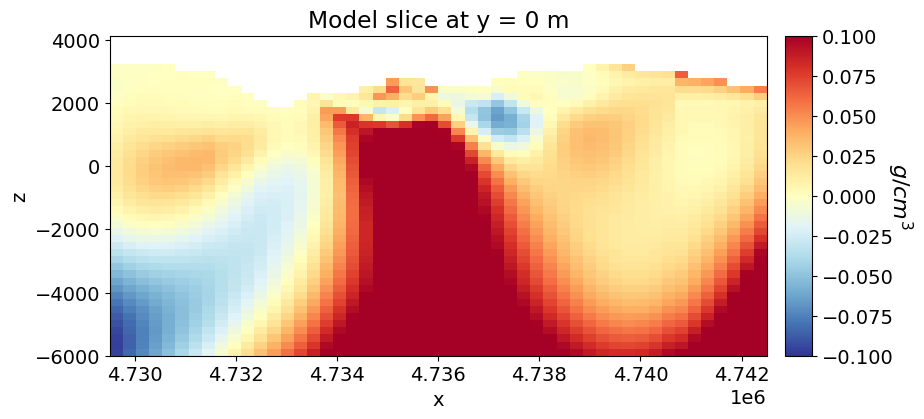

In [ ]:
# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_model), vmax=np.max(recovered_model)
    )

# norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.0)

mesh.plot_slice(
    tensor_plotting_map * recovered_model,
    normal="y",
    ax=ax1,
    slice_loc=2054372,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)


ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)



plt.show()

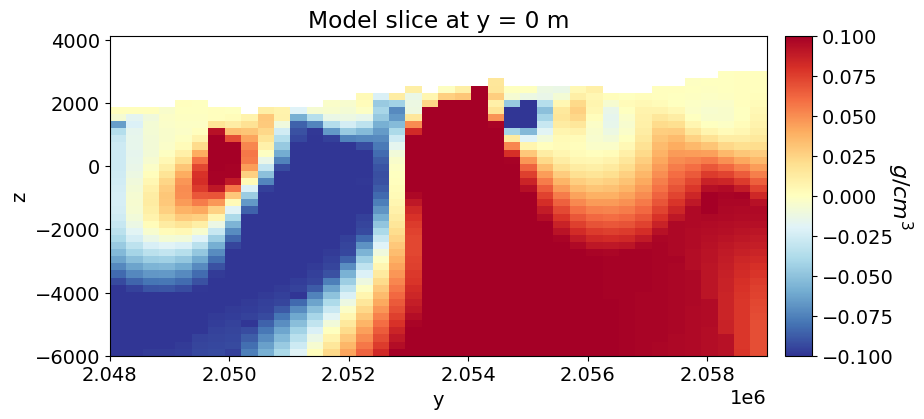

In [ ]:
# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_model), vmax=np.max(recovered_model)
    )

# norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.0)

mesh.plot_slice(
    tensor_plotting_map * recovered_model,
    normal="x",
    ax=ax1,
    slice_loc=4735600,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)


ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)



plt.show()

In [ ]:
k

In [ ]:
# Vector de modelo en celdas activas
susceptibility_active = tensor_model_map * recovered_model  # numpy array

# Rellena con NaN las inactivas
susceptibility_full = np.full(mesh.nC, np.nan)
susceptibility_full[active_tensor_cells] = susceptibility_active

cx = cell_centers[:, 0]
cy = cell_centers[:, 1]
cz = cell_centers[:, 2]

# Dimensiones de la malla (usa las que correspondan a tu tree_mesh)
nx, ny, nz = mesh.shape_cells 

# Volumen 3D para guardar/plotear
susceptibility_vol = susceptibility_full.reshape((nx, ny, nz), order="F")
active_mask = active_tensor_cells.reshape((nx, ny, nz), order="F")

np.savez(
    "AGCM_Susceptibility_contrast_model.npz",
    susceptibility=susceptibility_vol,
    model_nan = tensor_plotting_map * recovered_model,
    nx=cx, ny=cy, nz=cz,
)
print("Guardado AGCM_susceptibility_contrast_model.npz")

Guardado AGCM_susceptibility_contrast_model.npz


In [ ]:
# models = {'Susceptibilidad':tensor_plotting_map*recovered_model}
# databse = mesh.to_vtk(models)
# databse.save('modelo_susceptibilidad_mag_AGCM.vtk')

In [ ]:
from ipywidgets import widgets, interact

def plot_tikhonov_curve(iteration, scale):
    phi_d = []
    phi_m = []
    beta = []
    iterations = np.arange(len(save_iteration_new.outDict)) + 1
    for kk in iterations:
        phi_d.append(save_iteration_new.outDict[kk]['phi_d'])
        phi_m.append(save_iteration_new.outDict[kk]['phi_m'])
        beta.append(save_iteration_new.outDict[kk]['beta'])

    fig, axs = plt.subplots(1, 2, figsize=(12,5))

    # Primera gráfica
    axs[0].plot(phi_m, phi_d, 'k.-')
    axs[0].plot(phi_m[iteration-1], phi_d[iteration-1], 'go', ms=10)
    axs[0].set_xlabel("$\phi_m$")
    axs[0].set_ylabel("$\phi_d$")
    axs[0].grid(True)

    # Segunda gráfica
    line1 = axs[1].plot(iterations, phi_d, 'k.-', label='$\phi_d$')
    point1 = axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'go', ms=10)

    ax_1 = axs[1].twinx()
    line2 = ax_1.plot(iterations, phi_m, 'r.-', label='$\phi_m$')
    point2 = ax_1.plot(iterations[iteration-1], phi_m[iteration-1], 'go', ms=10)

    axs[1].set_ylabel("$\phi_d$")
    ax_1.set_ylabel("$\phi_m$")
    axs[1].set_xlabel("Iterations")
    axs[1].grid(True)

    # Añadir leyendas
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    axs[1].legend(lines, labels, loc='upper left')

    axs[0].set_title(
        "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
        fontsize = 14
    )
    axs[1].set_title("Target misfit={:.0f}".format(survey.nD/2))

    for ii, ax in enumerate(axs):
        if ii == 0:
            ax.set_xscale(scale)
        ax.set_yscale(scale)
        xlim = ax.get_xlim()
        ax.hlines(survey.nD/2, xlim[0], xlim[1], linestyle='--', label='$\phi_d^{*}$')
        ax.set_xlim(xlim)

    axs[0].legend()
    plt.tight_layout()

interact(
    plot_tikhonov_curve,
    iteration=widgets.IntSlider(min=1, max=len(save_iteration_new.outDict), step=1),
    scale=widgets.RadioButtons(options=["linear", "log"])
)

interactive(children=(IntSlider(value=1, description='iteration', max=12, min=1), RadioButtons(description='sc…

<function __main__.plot_tikhonov_curve(iteration, scale)>

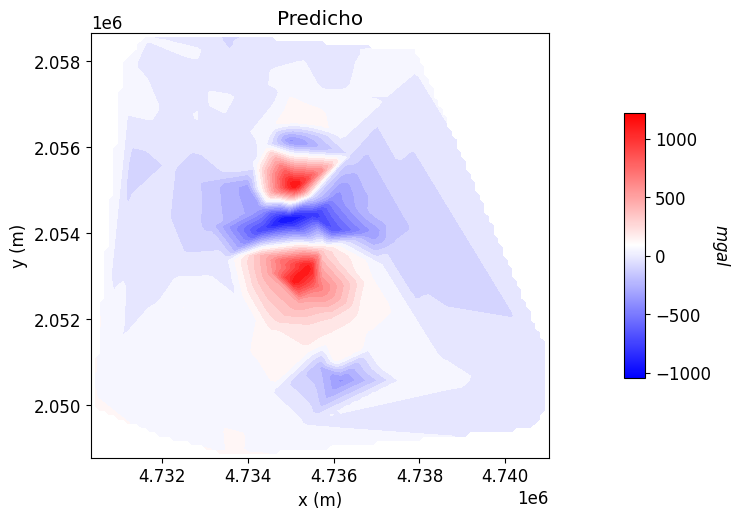

In [ ]:
dpred_new = (inv_prob_irls.dpred)

# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

v_lim = [np.min(dpred_new), np.max(dpred_new), np.min(-dpred_new), np.max(-dpred_new)]

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred_new,
    ax=ax1,
    ncontour=30,
    clim=(v_lim[0], v_lim[1]),
    contourOpts={"cmap": "bwr"})
ax1.set_title("Predicho")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=v_lim[0], vmax=v_lim[1])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

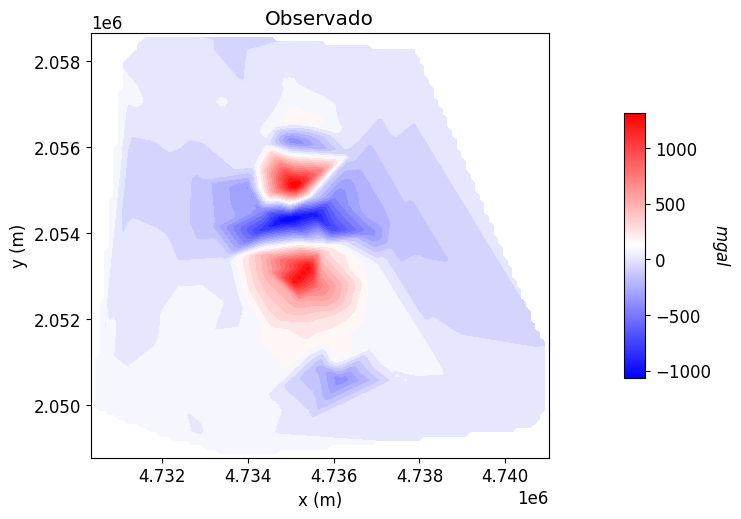

In [ ]:
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs, ax=ax1, ncontour=30, contourOpts={"cmap": "bwr"})
ax1.set_title("Observado")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-dobs), vmax=np.max(dobs))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

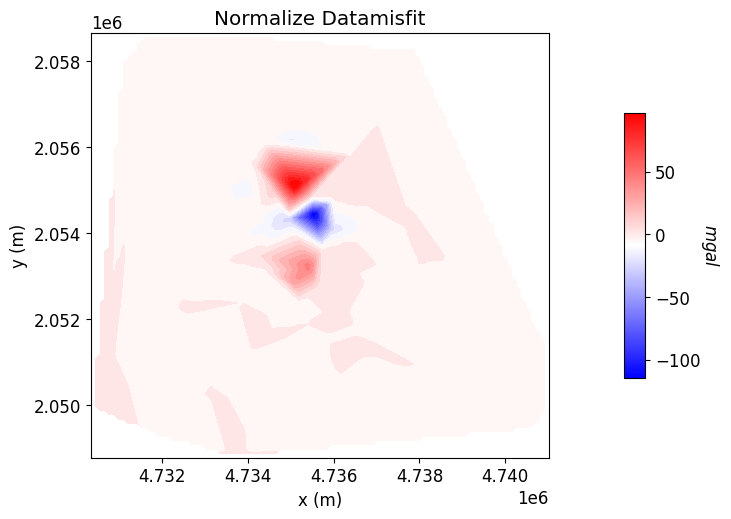

In [ ]:
data_misfit_new= (dobs - dpred_new)

mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations,
           data_misfit_new,
           ax=ax1,
           ncontour=30,
           contourOpts={"cmap": "bwr"})
ax1.set_title("Normalize Datamisfit")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-data_misfit_new), vmax=np.max(data_misfit_new))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [ ]:
import numpy as np

misfit = dobs - dpred_new
rms = np.sqrt(np.mean(misfit**2))
print(f"RMS (no ponderado): {rms:.4f}")

# Si quieres RMS ponderado por la incertidumbre que definiste en sigma:
wrms = np.sqrt(np.mean((misfit / sigma)**2))
print(f"RMS ponderado: {wrms:.4f}")


RMS (no ponderado): 15.3056
RMS ponderado: 0.8761


In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_recovered_model(iteration, xslice, yslice, zslice, use_optimization_limits=True, symmetric_limits=False):
    """
    Visualización del modelo recuperado con límites correctos.
    
    Parameters:
    -----------
    use_optimization_limits : bool
        Si True, usa los límites del optimizador. Si False, usa límites de los datos.
    symmetric_limits : bool
        Si True, fuerza límites simétricos (solo cuando use_optimization_limits=False).
    """

    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'figure.titlesize': 18
    })

    # Recuperar el modelo
    try:
        model = save_iteration_new.outDict[iteration]['m']
    except KeyError:
        print(f"Error: Iteración {iteration} no encontrada")
        return None
    
    # Mapear a la malla completa
    model_3d = tensor_plotting_map * model
    
    # Determinar límites de visualización
    if use_optimization_limits:
        # Usar los límites definidos en el optimizador
        # Manejar si son arrays o escalares
        vmin = opt_irls.lower if np.isscalar(opt_irls.lower) else opt_irls.lower[0]
        vmax = opt_irls.upper if np.isscalar(opt_irls.upper) else opt_irls.upper[0]
    else:
        # Usar límites basados en los datos
        valid_data = model_3d[~np.isnan(model_3d)]
        vmin = np.percentile(valid_data, 1)
        vmax = np.percentile(valid_data, 99)
        
        # Solo aplicar simetría si se solicita explícitamente
        if symmetric_limits and vmin < 0 and vmax > 0:
            vlim = max(abs(vmin), abs(vmax))
            vmin, vmax = -vlim, vlim
    
    # Crear figura
    fig = plt.figure(figsize=(8, 8))
    
    # Plot 3D
    mesh.plot_3d_slicer(
        model_3d,
        clim=[vmin, vmax],
        xslice=xslice,
        yslice=yslice,
        zslice=zslice,
        fig=fig,
        pcolor_opts={'cmap': 'RdYlBu_r'},
        show_slice_lines=False  # AÑADE ESTA LÍNEA
    )
    
    # Título
    fig.suptitle(f'Modelo de Densidad - Iteración {iteration}', fontsize=16, y=0.98)
    
    # Estadísticas con límites reales
    valid_data = model_3d[~np.isnan(model_3d)]
    actual_min = np.min(valid_data)
    actual_max = np.max(valid_data)
    
    stats_text = f'Datos: Min: {actual_min:.3f} | Max: {actual_max:.3f} | Media: {np.mean(valid_data):.3f} g/cm³'
    limits_text = f'Visualización: [{vmin:.3f}, {vmax:.3f}] g/cm³'
    
    # Información de convergencia
    if 'phi_d' in save_iteration_new.outDict[iteration]:
        phi_d = save_iteration_new.outDict[iteration]['phi_d']
        phi_m = save_iteration_new.outDict[iteration]['phi_m']
        beta = save_iteration_new.outDict[iteration]['beta']
        conv_text = f'φd: {phi_d:.2e} | φm: {phi_m:.2e} | β: {beta:.2e}'

    
    return fig

# Configuración
available_iterations = list(save_iteration_new.outDict.keys())

if available_iterations:
    # Valores por defecto
    x_center = mesh.cell_centers[:, 0].mean()
    y_center = mesh.cell_centers[:, 1].mean()
    z_center = mesh.cell_centers[:, 2].mean()
    
    # Variable global para la figura
    current_figure = None
    
    # Crear widgets específicos
    iteration_slider = widgets.IntSlider(
        value=max(available_iterations),
        min=min(available_iterations),
        max=max(available_iterations),
        step=1,
        description='Iteración:',
        style={'description_width': 'initial'},
        continuous_update=False
    )
    
    xslice_text = widgets.FloatText(
        value=x_center,
        step=100,
        description='Corte X (m):',
        style={'description_width': 'initial'}
    )
    
    yslice_text = widgets.FloatText(
        value=y_center,
        step=100,
        description='Corte Y (m):',
        style={'description_width': 'initial'}
    )
    
    zslice_text = widgets.FloatText(
        value=z_center,
        step=50,
        description='Corte Z (m):',
        style={'description_width': 'initial'}
    )
    
    # Nuevos widgets para control de límites
    use_opt_limits = widgets.Checkbox(
        value=True,
        description='Usar límites del optimizador',
        style={'description_width': 'initial'}
    )
    
    symmetric_check = widgets.Checkbox(
        value=False,
        description='Forzar límites simétricos',
        disabled=True,  # Deshabilitado cuando se usan límites del optimizador
        style={'description_width': 'initial'}
    )
    
    # Widget de salida
    output = widgets.Output()
    
    # Función para manejar el cambio de checkbox
    def on_use_opt_change(change):
        symmetric_check.disabled = change['new']
        update_plot()
    
    use_opt_limits.observe(on_use_opt_change, 'value')
    
    # Función de actualización
    def update_plot(*args):
        global current_figure
        with output:
            output.clear_output(wait=True)
            current_figure = plot_recovered_model(
                iteration_slider.value,
                xslice_text.value,
                yslice_text.value,
                zslice_text.value,
                use_optimization_limits=use_opt_limits.value,
                symmetric_limits=symmetric_check.value
            )
            plt.show()
    
    # Conectar eventos
    iteration_slider.observe(update_plot, 'value')
    xslice_text.observe(update_plot, 'value')
    yslice_text.observe(update_plot, 'value')
    zslice_text.observe(update_plot, 'value')
    use_opt_limits.observe(update_plot, 'value')
    symmetric_check.observe(update_plot, 'value')
    
    # Función para guardar
    def save_current_svg(filename='modelo.png'):
        global current_figure
        if current_figure is not None:
            os.makedirs('figures', exist_ok=True)
            if not filename.endswith('.png'):
                filename += '.png'
            filepath = f'figures/{filename}'
            current_figure.savefig(filepath, format='png', bbox_inches='tight', dpi=300)
            print(f"✓ Guardado: {filepath}")
            print(f"  Tamaño del archivo: {os.path.getsize(filepath)/1024:.1f} KB")
        else:
            print("⚠ Primero actualice la visualización usando los controles")
    
    # Crear layout
    controls = widgets.VBox([
        iteration_slider,
        widgets.HBox([xslice_text, yslice_text, zslice_text]),
        widgets.HBox([use_opt_limits, symmetric_check])
    ])
    
    # Mostrar interfaz
    display(widgets.VBox([controls, output]))
    
    # Actualización inicial
    update_plot()
    
    # Instrucciones mejoradas
    print("="*70)
    print("INFORMACIÓN DE LA VISUALIZACIÓN:")
    print(f"   • Iteraciones disponibles: {min(available_iterations)} - {max(available_iterations)}")
    print(f"   • Dimensiones de la malla: {mesh.nC} celdas")
    print(f"   • Rango X: {mesh.cell_centers[:, 0].min():.0f} - {mesh.cell_centers[:, 0].max():.0f} m")
    print(f"   • Rango Y: {mesh.cell_centers[:, 1].min():.0f} - {mesh.cell_centers[:, 1].max():.0f} m")
    print(f"   • Rango Z: {mesh.cell_centers[:, 2].min():.0f} - {mesh.cell_centers[:, 2].max():.0f} m")
    print("-"*70)
    print("LÍMITES DEL OPTIMIZADOR:")
    # Manejar si son arrays o escalares
    lower_val = opt_irls.lower if np.isscalar(opt_irls.lower) else opt_irls.lower[0]
    upper_val = opt_irls.upper if np.isscalar(opt_irls.upper) else opt_irls.upper[0]
    print(f"   • Límite inferior: {lower_val:.3f} g/cm³")
    print(f"   • Límite superior: {upper_val:.3f} g/cm³")
    print("="*70)

else:
    print("❌ No hay iteraciones disponibles en save_iteration_new.outDict")

# Función adicional para análisis de la distribución del modelo
def analyze_model_distribution(iteration=-1):
    """
    Analiza la distribución de valores del modelo recuperado
    """
    if iteration == -1:
        iteration = max(available_iterations)
    
    model = save_iteration_new.outDict[iteration]['m']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Obtener valores de límites (manejar arrays)
    lower_val = opt_irls.lower if np.isscalar(opt_irls.lower) else opt_irls.lower[0]
    upper_val = opt_irls.upper if np.isscalar(opt_irls.upper) else opt_irls.upper[0]
    
    # Histograma
    ax1.hist(model, bins=50, edgecolor='black', alpha=0.7)
    ax1.axvline(lower_val, color='red', linestyle='--', label=f'Límite inferior: {lower_val}')
    ax1.axvline(upper_val, color='red', linestyle='--', label=f'Límite superior: {upper_val}')
    ax1.axvline(np.mean(model), color='green', linestyle='-', label=f'Media: {np.mean(model):.3f}')
    ax1.set_xlabel('Densidad (g/cm³)')
    ax1.set_ylabel('Número de celdas')
    ax1.set_title(f'Distribución del modelo - Iteración {iteration}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Box plot con estadísticas
    ax2.boxplot(model, vert=True, patch_artist=True)
    ax2.set_ylabel('Densidad (g/cm³)')
    ax2.set_title('Estadísticas del modelo')
    
    # Añadir líneas de límites
    ax2.axhline(lower_val, color='red', linestyle='--', alpha=0.5)
    ax2.axhline(upper_val, color='red', linestyle='--', alpha=0.5)
    
    # Estadísticas
    stats_text = f"Min: {np.min(model):.3f}\n"
    stats_text += f"Q1: {np.percentile(model, 25):.3f}\n"
    stats_text += f"Mediana: {np.median(model):.3f}\n"
    stats_text += f"Q3: {np.percentile(model, 75):.3f}\n"
    stats_text += f"Max: {np.max(model):.3f}\n"
    stats_text += f"Std: {np.std(model):.3f}"
    
    ax2.text(1.2, 0.5, stats_text, transform=ax2.transAxes, 
             verticalalignment='center', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Verificar si hay valores en los límites
    at_lower = np.sum(np.isclose(model, lower_val, rtol=1e-5))
    at_upper = np.sum(np.isclose(model, upper_val, rtol=1e-5))
    
    if at_lower > 0 or at_upper > 0:
        print(f"⚠ ATENCIÓN: {at_lower} celdas en límite inferior, {at_upper} celdas en límite superior")
        print("  Esto puede indicar que los límites son muy restrictivos")

INFORMACIÓN DE LA VISUALIZACIÓN:
   • Iteraciones disponibles: 1 - 12
   • Dimensiones de la malla: 90000 celdas
   • Rango X: 4729630 - 4742370 m
   • Rango Y: 2048138 - 2058862 m
   • Rango Z: -5888 - 4012 m
----------------------------------------------------------------------
LÍMITES DEL OPTIMIZADOR:
   • Límite inferior: -0.100 g/cm³
   • Límite superior: 0.100 g/cm³
